In [101]:
import os
import numpy as np
from simsopt.configs import get_ncsx_data
from simsopt.field import BiotSavart, coils_via_symmetries
from simsopt.geo import BoozerSurface, boozer_surface_residual, ToroidalFlux, Area, SurfaceXYZTensorFourier, Volume
from simsopt.geo import SurfaceRZFourier
from simsopt.mhd.vmec import Vmec
from simsopt._core import load

# load the coils 
bs = load('output/biot_savart_opt_paper.json')
coils = bs.coils
current_sum = sum(abs(c.current.get_value()) for c in coils)
G0 = 2. * np.pi * current_sum * (4 * np.pi * 10**(-7) / (2 * np.pi))
print('G0: ',G0)

mpol = 8  # try increasing this to 8 or 10 for smoother surfaces
ntor = 8 # try increasing this to 8 or 10 for smoother surfaces
stellsym = True
nfp = 2
nphi = 50
ntheta = 50
filename = '../../tests/test_files/input.LandremanPaul2021_QA'
# load the surface
surf_vmec = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
vmec = Vmec(filename)



G0:  2.010619293986814
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.LandremanPaul2021_QA
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Aug 28,2024  TIME = 17:18:42


In [102]:
# compute iota on the boundary
vmec.iota_edge()


  NS =   12 NO. FOURIER MODES =  388 FTOLV =  1.000E-17 NITER =   1200
  PROCESSOR COUNT - RADIAL:    1
 INITIAL JACOBIAN CHANGED SIGN!
 TRYING TO IMPROVE INITIAL MAGNETIC AXIS GUESS
  ---- Improved AXIS Guess ----
      RAXIS_CC =    1.0247091160392592       0.17873725576417121        2.3817977437963236E-002  -2.1505235462961924E-003  -1.0974049866712924E-003  -4.6577026180301889E-005   4.3751733335398440E-004   7.2256704125254155E-004  -6.3317438000295100E-004   4.5140773614725787E-004  -1.0376265915601820E-003  -2.0467645788777800E-004   9.2127010026191766E-004
      ZAXIS_CS =   -0.0000000000000000      -0.16617742012666295       -1.7156594180066310E-002  -9.4235091153126464E-004  -1.0359849278373297E-003  -1.8651026897195360E-003  -1.4227073884798816E-003  -4.7806686255382239E-004  -8.9560392584564529E-004   1.9489073942383301E-004  -7.9041061675539975E-004  -4.5043968802392019E-004  -4.1654785510247382E-004
  -----------------------------

  ITER    FSQR      FSQZ      FSQL    R

0.4157687780205037

In [103]:
phis = np.linspace(0, 1/nfp, nphi, endpoint=False)
thetas = np.linspace(0, 1, ntheta, endpoint=False)

surf_prev = SurfaceRZFourier(mpol=surf_vmec.mpol,ntor=surf_vmec.ntor,stellsym=surf_vmec.stellsym,nfp=nfp,quadpoints_phi=phis,
                                   quadpoints_theta=thetas)
surf_prev.set_dofs(surf_vmec.get_dofs())
s0 = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
vol_target = Volume(s0).J()

# iterate to solve for the surface with correct Boozer angles
for mpol in [6,8,10]:
    print("mpol="+f"{mpol}")
    s = SurfaceXYZTensorFourier(
        mpol=mpol, ntor=mpol, stellsym=stellsym, nfp=nfp, quadpoints_phi=phis, quadpoints_theta=thetas)
    s.least_squares_fit(surf_prev.gamma())
    iota = vmec.wout.iotas[-1]
    print('iota: ',iota)
    
    vol = Volume(s)
    constraint_weight = 1
    
    boozer_surface = BoozerSurface(bs, s, vol, vol_target, constraint_weight)
    res = boozer_surface.run_code(iota, G0)
    print(res['G'])
    print(res['iota'])
    s_prev = s

mpol=6
iota:  0.41578442817618416
BFGS solve - True  iter=288, iota=0.4153897620663775, ||grad||_inf = 8.616e-11
NEWTON solve - True  iter=1, iota=0.4153897620476901, ||grad||_inf = 1.074e-15
2.010619293986814
0.41538976204769007
mpol=8
iota:  0.41578442817618416
BFGS solve - True  iter=466, iota=0.4156127203788054, ||grad||_inf = 2.488e-11
NEWTON solve - True  iter=1, iota=0.4156127203828922, ||grad||_inf = 7.510e-16
2.010619293986814
0.41561272038289215
mpol=10
iota:  0.41578442817618416
BFGS solve - True  iter=697, iota=0.4155890370918206, ||grad||_inf = 9.924e-11
NEWTON solve - True  iter=1, iota=0.4155890370882189, ||grad||_inf = 1.860e-14
2.010619293986814
0.4155890370882189


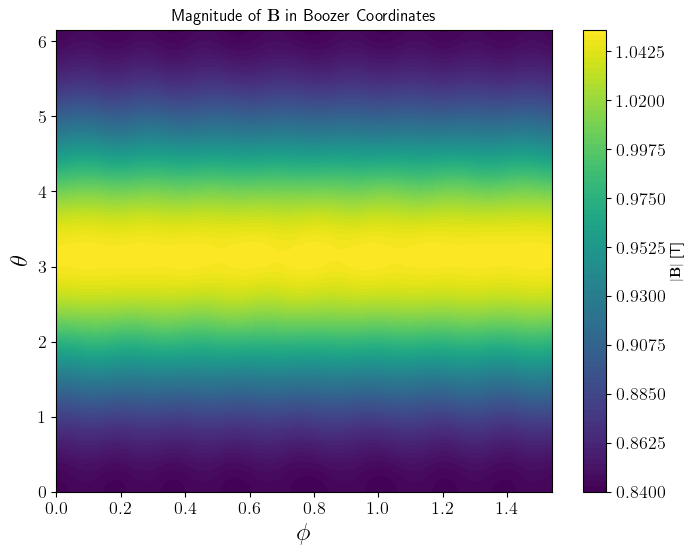

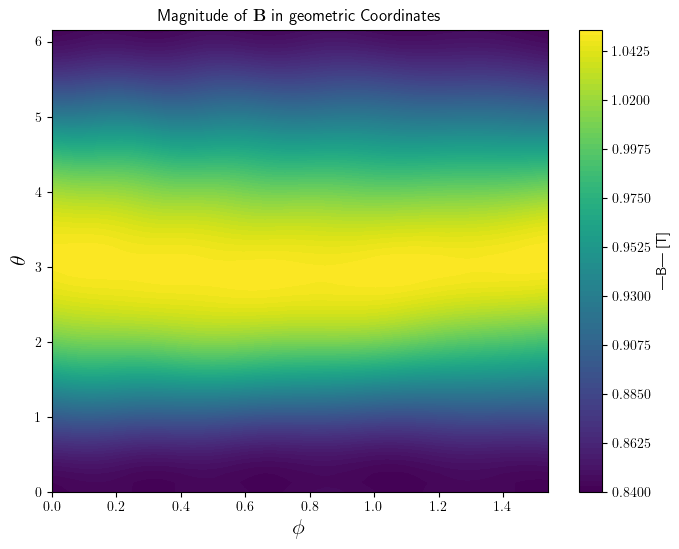

'{\n  "@module": "simsopt._core.json",\n  "@class": "SIMSON",\n  "@version": "1.6.5.dev0+gf4b943eb.d20240803",\n  "graph": {\n    "$type": "ref",\n    "value": "SurfaceXYZTensorFourier12"\n  },\n  "simsopt_objs": {\n    "6065715712": {\n      "@module": "simsopt._core.optimizable",\n      "@class": "DOFs",\n      "@name": "6065715712",\n      "@version": "1.6.5.dev0+gf4b943eb.d20240803",\n      "x": {\n        "@module": "numpy",\n        "@class": "array",\n        "dtype": "float64",\n        "data": [\n          1.028371035031629,\n          0.1684387789873072,\n          0.004588283521949367,\n          7.918049950441827e-05,\n          4.0725201396031364e-06,\n          -3.1498295474898303e-06,\n          -1.2070906101314325e-06,\n          -3.538382731802775e-05,\n          4.32699004878799e-05,\n          3.0504712226443124e-05,\n          7.376684480891624e-06,\n          0.15831977062611619,\n          -0.07166670293941611,\n          -0.00499081039178244,\n          -0.000228

: 

In [105]:
phis = np.linspace(0, np.pi/nfp, nphi, endpoint=False)
thetas = np.linspace(0, 2*np.pi, ntheta, endpoint=False)

# extract field from the previously computed Boozer surface
field = boozer_surface.biotsavart
Bsurf = field.B().reshape(nphi, ntheta,3)
modB = np.linalg.norm(Bsurf, axis=2)
[Phi,Theta] = np.meshgrid(phis,thetas)

# Plot modB in Boozer coordinates
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8, 6))
plt.contourf(Phi, Theta, np.pi*modB.T, levels=100
             , cmap='viridis')
cbar = plt.colorbar(label='$|\mathbf{B}|$ [T]')
cbar.ax.tick_params(labelsize=13)

plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$\theta$', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Magnitude of $\mathbf{B}$ in Boozer Coordinates')
plt.savefig("modB_boozer_from_coils.pdf", dpi=300)
plt.show()


surf_0 = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
bs_0 = BiotSavart(coils)
bs_0.set_points(surf_0.gamma().reshape((-1, 3)))
B0 = bs_0.B().reshape(nphi,ntheta,3)
modB0 = np.linalg.norm(B0, axis=2)

# Plot modB in regular coordinates
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.contourf(Phi, Theta, np.pi*modB0.T, levels=100
             , cmap='viridis')
plt.colorbar(label='|B| [T]')
plt.xlabel(r'$\phi$', fontsize=16)
plt.ylabel(r'$\theta$', fontsize=16)
plt.title('Magnitude of $\mathbf{B}$ in geometric Coordinates')
plt.show()

# save surface 
pointdata = {'modB': np.linalg.norm(Bsurf, axis=2)[:, :, None] }
s.to_vtk('output/surf_booz', extra_data=pointdata)
s.save('output/boozer_surf.json')